# TSNE

In [1]:
import numpy as np
import pandas as pd
import cv2
import torch
from sklearn import preprocessing
import torchvision.models as models
#from torchsummary import summary
import torch.nn as nn
from src.models import WhaleDoModel
from sklearn.model_selection import StratifiedKFold, train_test_split
from src.utils import *
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import torch
#import imutils
import tensorflow as tf
from src.dataloader import WhaleDoDataset
import pickle as pkl
from pytorch_metric_learning import losses, miners
from torch.utils.data import DataLoader
from src.config import get_config
from tqdm import tqdm

## Get train_df

In [2]:
config = get_config()
# load and parse the dataframe and get the label encoder as well
train_df, label_encoder = load_csv_and_parse_dataframe(config['csv_name'], root_dir=config['root_dir'], drop_columns=['timestamp', 'encounter_id'])
# get the average height and width of the dataset (rotate if viewpoint -1 or 1 (left / right))
config['dataset']['height'], config['dataset']['width'] = get_avg_height_width(train_df)
# get the mean and std of the dataset
config['dataset']['mean'], config['dataset']['std'] = get_mean_and_std_of_dataset(train_df)
# create the dataset objects
train_data = WhaleDoDataset(train_df, config, mode='train')
train_loader = DataLoader(train_data, 8, shuffle=True)

train_df = train_df.reset_index()
train_df.head()

,image_id,path,height,width,viewpoint,date,whale_id
0,train0000,data/images/train0000.jpg,463,150,0,2017-08-07,0
1,train0001,data/images/train0001.jpg,192,81,0,2019-08-05,1
2,train0002,data/images/train0002.jpg,625,183,0,2017-08-07,2
3,train0003,data/images/train0003.jpg,673,237,0,2017-08-07,3
4,train0004,data/images/train0004.jpg,461,166,0,2018-08-10,4


## Get three samples from train_df
In this part a row from train_df is randomly sampled (the anchor). If there are more whale_id's of this sample in train_df, the program will select randomly another row with the same whale_id (the positive). After that it will select a row which does not have this whale_id (the negative).

In [3]:
# # cell to get the samples from the train_df
# matched = False

# while matched == False:
#     random_sample = train_df.sample()
#     index = random_sample.index[0]
#     random_sample_id = int(random_sample['whale_id'])
#     random_sample_image_id = random_sample['image_id'].tolist()[0]
    
#     positive_df = train_df.loc[train_df['whale_id']== random_sample_id]
#     positive_df = positive_df[positive_df.image_id != random_sample_image_id]
#     row_count = len(positive_df.head())

    
#     if row_count > 1:
#         positive = positive_df.sample()
#         index_positive = positive.index[0]
#         negative =  train_df.loc[train_df['whale_id'] != random_sample_id].sample()
#         index_neg = negative.index[0]
#         matched = True

In [4]:
# random_sample.head()

In [5]:
# positive.head()

In [6]:
# negative.head()

In [7]:
# print('indexes are: ', index, index_positive, index_neg)

## Use __getitem__ and make a model

In [8]:
# get the three items
# anchor_item = train_data.__getitem__(index)
# positive_item = train_data.__getitem__(index_positive)
# negative_item = train_data.__getitem__(index_neg)

In [9]:
# print(anchor_item)
# print(positive_item)
# print(negative_item)

In [10]:
# from old code
# init loss function and a miner. The miner samples for training samples
# init model and optimizer
model = WhaleDoModel(config).to(config['device']).eval()
model.projector = None


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/appuser/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/srv/conda/envs/condaenv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Make x_batch and y_batch

In [11]:
# # make the three items into tensors and concatenate them into x_batch and y_batch
# anchor_x, anchor_y = anchor_item['image'], anchor_item['label']
# positive_x, positive_y = positive_item['image'], positive_item['label']
# negative_x, negative_y = negative_item['image'], negative_item['label']

# # torch.cat is to concatenate along existing dimensions
# # x_batch = torch.cat((anchor_x,positive_x,negative_x),1).to(config['device'])
# # stack is to create a new dimension (batches) for the batches. You could also manually create a singleton dimension
# # in the first position and then use torch.cat(..., 0)
# x_batch = torch.stack((anchor_x,positive_x,negative_x),0).to(config['device'])
# y_batch = torch.tensor((anchor_y,positive_y,negative_y)).to(config['device'])

# print(x_batch.shape)
# print(y_batch.shape)

## Get the Embeddings 

In [12]:
#set the gradients to zero
#compute embeddings
embeddings_batch = []
classes_batch = []

for i, batch in enumerate(tqdm(train_loader, total=len(train_loader))):
    x_batch, y_batch = batch['image'].to(config['device']), batch['label'].to(config['device'])
    
    embeddings_batch.append(model(x_batch))
    classes_batch.append(y_batch)
    
    if i == 10:
        break

embeddings = torch.cat(embeddings_batch, dim=0)
classes = torch.cat(classes_batch, dim=0)

  1%|▉                                                                       | 10/738 [00:10<13:14,  1.09s/it]


# Plot TSNE plots in 2D and 3D

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embeddings_array = embeddings.cpu().detach().numpy() # otherwise it doesn't work

tsne = TSNE(random_state = 0, n_iter = 1000, metric = 'cosine')
embeddings2d = tsne.fit_transform(embeddings_array)

# Create DF
embeddingsdf = pd.DataFrame()

# Add game names
embeddingsdf['classes'] = list(classes.cpu().detach().numpy())

# Add x coordinate
embeddingsdf['x'] = embeddings2d[:,0]
# Add y coordinate
embeddingsdf['y'] = embeddings2d[:,1]
# Check
embeddingsdf.head()

/srv/conda/envs/condaenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


,classes,x,y
0,513,-3.715269,0.792225
1,782,-5.909158,2.136669
2,89,-4.301981,-2.000796
3,50,-1.419810,0.336813
4,66,-2.850097,1.215942


In [14]:
embeddingsdf.shape

(88, 3)

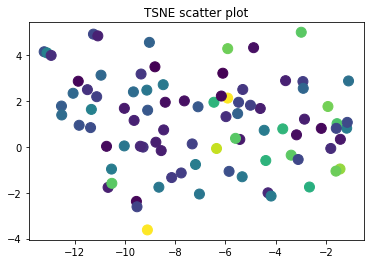

In [15]:
# Set figsize
# Scatter points, set alpha low to make points translucent
anchor = plt.scatter(embeddingsdf.x, embeddingsdf.y, c=embeddingsdf.classes, s=100)
plt.title('TSNE scatter plot')
plt.show()

## Please extend for 3d as well

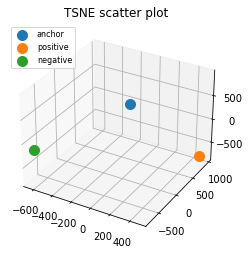

In [15]:
embeddings3d = TSNE(n_components=3, random_state=0).fit_transform(embeddings_array)
# Create DF
embeddingsdf_3d = pd.DataFrame()

# Add game names
embeddingsdf_3d['Image'] = ['anchor','positive', 'negative']

# Add x coordinate
embeddingsdf_3d['x'] = embeddings3d[:,0]
# Add y coordinate
embeddingsdf_3d['y'] = embeddings3d[:,1]
# Add z coordinate
embeddingsdf_3d['z'] = embeddings3d[:,2]
# Check
embeddingsdf_3d.head()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
anchor = ax.scatter(embeddingsdf_3d.x[0], embeddingsdf_3d.y[0],embeddingsdf_3d.z[0], s= 100)
positive = ax.scatter(embeddingsdf_3d.x[1], embeddingsdf_3d.y[1],embeddingsdf_3d.z[1], s= 100)
negative = ax.scatter(embeddingsdf_3d.x[2], embeddingsdf_3d.y[2],embeddingsdf_3d.z[2], s= 100)
plt.legend((anchor,positive,negative),
           ('anchor', 'positive', 'negative'),
           scatterpoints=1,
           loc='upper left',
           ncol=1,
           fontsize=8)
plt.title('TSNE scatter plot')
plt.show()